# Проектная работа: "Викишоп"

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

В нашем распоряжении набор данных с разметкой о токсичности правок. **Целью данной работы** является построение модели классификации комментариев на позитивные и негативные.

**Примечание**: метрика качества F1 должна быть не меньше 0.75.

**Описание данных**:
- `text` - текст комментария;
- `toxic` - целевой признак.

**План работы**:

1. Загрузка и подготовка данных;
2. Обучение разных моделей;
3. Общие выводы.

### Шаг 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import warnings
from pymystem3 import Mystem
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, make_scorer, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import Pool, CatBoostClassifier, metrics, cv
from math import ceil
from lightgbm import LGBMClassifier, Dataset


warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# загрузим данные и укажем первый столбец как индекс таблицы
df = pd.read_csv("toxic_comments.csv", index_col = [0])
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
df.columns

Index(['text', 'toxic'], dtype='object')

In [4]:
print("Количество строк в датасете:", "{:,.0f}".format(df.shape[0]))

Количество строк в датасете: 159,292


Посмотрим на распределение позитивных и негативных комментариев. Мы ожидаем дисбаланс между ними. При обучении моделей нужно будет учитывать это.

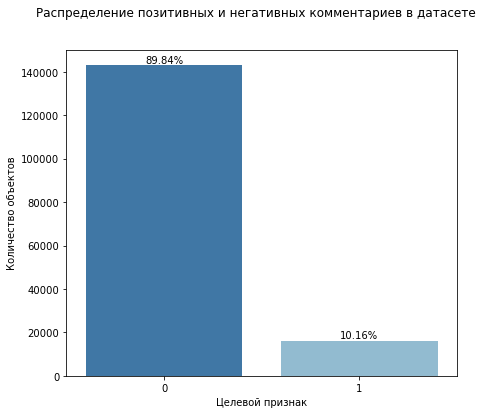

In [5]:
fig, ax = plt.subplots(figsize = (7, 6))

sns.countplot(x = df["toxic"], order = df["toxic"].value_counts(ascending = False).index,
                    palette = sns.color_palette("RdBu_r"), ax = ax)

ax.bar_label(container = ax.containers[0],
             labels = ["{:,.2%}".format(i) for i in df["toxic"].value_counts(ascending = False, 
                                                                                   normalize = True).values])
ax.set(xlabel = "Целевой признак", ylabel = "Количество объектов")

fig.suptitle("Распределение позитивных и негативных комментариев в датасете")
plt.show()

Таким образом, дисбаланс классов подтвердился. Количество негативных комментариев практически в 9 больше, чем позитивных. Перед обучением моделей мы исправим дисбаланс, а пока продолжим подготовку данных.  

In [6]:
%%time

m = Mystem()

def lemmatize_text(text):
    text = text.lower()
    lemm_text = "".join(m.lemmatize(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

df["lemm_text"] = df["text"].apply(lemmatize_text)
df = df.drop("text", axis = 1)

CPU times: user 26 s, sys: 3.59 s, total: 29.6 s
Wall time: 1min 34s


In [7]:
df.head()

,toxic,lemm_text
0,0,explanation why the edits made under my userna...
1,0,d aww he matches this background colour i m se...
2,0,hey man i m really not trying to edit war it s...
3,0,more i can t make any real suggestions on impr...
4,0,you sir are my hero any chance you remember wh...


На текущем этапе мы завершим подготовку данных на лемматизации. Так как мы будем применять `upsampling` и `downsampling`, чтобы подоброть дисбаланс классов, то нам нужно будет подготовить три набора датасетов. Поэтому создание мешка слов и классификацию тональности текста проделаем позднее.

### Шаг 2. Обучение разных моделей

Так как после создания мешка слов и классификации тональности текста возвращается объект типа `scipy.sparse.csr.csr_matrix`, то в процессе `upsampling` и `downsampling` мы не сможем конкатинизовать его, необходимое для слияния всех таблиц воедино. Поэтому нам придется создать лишние наборы данных с признакми и таргетами. Тем не менее, тестировать модели мы будем на выборке, которую созданим в основном разбиении данных.

Минимизировать будет функция потерь - `log_loss` (логистическая функция ошибки), а качество модели оценим с помощью F1-метрики.

##### Оценка моделей до исправления дисбаланса классов

In [8]:
base_features = df.drop("toxic", axis = 1)
base_target = df.drop("lemm_text", axis = 1)

In [9]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
count_tf_idf = TfidfVectorizer(stop_words = stop_words)


features = count_tf_idf.fit_transform(base_features["lemm_text"].values.astype('U'))
target = df.drop("lemm_text", axis = 1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amirgafurov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Разделим датасет на обучающую и тестовую. Доля тестовой выборки составит 20%, на обучающей выборке сможем провести кросс-валидацию.

In [10]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                target, test_size = 0.2, random_state = 12345)


print("Размерность обучающего набора признаков:", features_train.shape)
print("Размерность тестового набора признаков:", features_test.shape)

Размерность обучающего набора признаков: (127433, 169757)
Размерность тестового набора признаков: (31859, 169757)


##### Логистическая регрессия

In [11]:
base_logistic_regression = GridSearchCV(
    LogisticRegression(random_state = 12345), param_grid = {"penalty" : ["l1", "l2", "elasticnet", None]},
    cv = 5, scoring = make_scorer(log_loss)
)

In [12]:
base_logistic_regression.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=12345),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet', None]},
             scoring=make_scorer(log_loss))

In [13]:
print("Параметры лучшей модели:", base_logistic_regression.best_params_)

Параметры лучшей модели: {'penalty': 'l2'}


In [14]:
base_logistic_regression_score = base_logistic_regression.best_score_

print("Значение функции потерь в результате обучения логистической модели:", 
      "{:,.2f}".format(base_logistic_regression_score))

Значение функции потерь в результате обучения логистической модели: 1.64


##### Решающее дерево

In [15]:
base_decision_tree = GridSearchCV(
    DecisionTreeClassifier(random_state = 12345),
    param_grid = {"max_depth" : np.arange(1, 11, 2)},
    cv = 5, scoring = make_scorer(log_loss)
)

In [16]:
base_decision_tree.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'max_depth': array([1, 3, 5, 7, 9])},
             scoring=make_scorer(log_loss))

In [17]:
print("Параметры лучшей модели:", base_decision_tree.best_params_)

Параметры лучшей модели: {'max_depth': 1}


In [18]:
base_decision_tree_score = base_decision_tree.best_score_

print("Значение функции потерь в результате обучения решающего дерева:", 
      "{:,.2f}".format(base_decision_tree_score))

Значение функции потерь в результате обучения решающего дерева: 2.98


##### CatBoostClassifier

In [19]:
base_pool = Pool(features_train, target_train)

In [20]:
base_catboost = CatBoostClassifier(iterations = 1000, learning_rate = 0.5, random_state = 12345)

In [21]:
base_catboost.fit(base_pool, early_stopping_rounds = 50, verbose = False, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
base_catboost_score = base_catboost.get_best_score()["learn"]["Logloss"]

print("Значение функции потерь в результате обучения решающего дерева:", 
      "{:,.2f}".format(base_catboost_score))

Значение функции потерь в результате обучения решающего дерева: 0.05


##### LGBMClassifier

In [23]:
base_lgbm = GridSearchCV(
    LGBMClassifier(n_estimators = 1000, random_state = 12345),
    param_grid = {"learning_rate" : [0.3, 0.5, 0.7]},
    cv = 5, scoring = make_scorer(log_loss)
)

In [24]:
base_lgbm.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=LGBMClassifier(n_estimators=1000, random_state=12345),
             param_grid={'learning_rate': [0.3, 0.5, 0.7]},
             scoring=make_scorer(log_loss))

In [25]:
print("Параметры лучшей модели:", base_lgbm.best_params_)

Параметры лучшей модели: {'learning_rate': 0.7}


In [26]:
base_lgbm_score = base_lgbm.best_score_

print("Значение функции потерь в результате обучения решающего дерева:", 
      "{:,.2f}".format(base_lgbm_score))

Значение функции потерь в результате обучения решающего дерева: 14.35


##### Выбор лучшей модели

Для выбора лучшей модели создадим отдельную таблицу со значениями `Log-loss`.

In [27]:
index = ["Logistic regression", "Decision tree", "CatBoostClassifier", "LGBMClassifier"]
data = {"Log-loss" : [base_logistic_regression_score, 
                     base_decision_tree_score, base_catboost_score, base_lgbm_score]}
base_model = pd.DataFrame(data = data, index = index)
base_model

,Log-loss
Logistic regression,1.642202
Decision tree,2.978944
CatBoostClassifier,0.054081
LGBMClassifier,14.348638


Таким образом, лучшей моделью становится `CatBoostClassifier`. Посчитаем F1-метрику для нее.

In [28]:
base_catboost_predict = base_catboost.predict(features_test)

In [29]:
confusion_matrix(target_test, base_catboost_predict)

array([[28338,   291],
       [ 1033,  2197]])

Среди всех объектов, предсказанных положительным классом, 68% действительно оказались положительными.

In [30]:
print("Значение метрики recall:", "{:,.2%}".format(recall_score(target_test, base_catboost_predict)))

Значение метрики recall: 68.02%


Наша модель корректно определила чуть больше 88% среди всех положительных ответов.

In [31]:
print("Значение метрики precision:", "{:,.2%}".format(precision_score(target_test, base_catboost_predict)))

Значение метрики precision: 88.30%


In [32]:
print("F1-метрика:", "{:,.2f}".format(f1_score(target_test, base_catboost_predict)))

F1-метрика: 0.77


F1-мера составляет 0.77, что выше целевого значения в 0.75.

In [33]:
base_catboost_probabilities = base_catboost.predict_proba(features_test)
base_catboost_probabilities_one = base_catboost_probabilities[:, 1]

print("Значение метрики ROC-AUC:", "{:,.2%}".format(roc_auc_score(target_test, base_catboost_probabilities_one)))

Значение метрики ROC-AUC: 96.34%


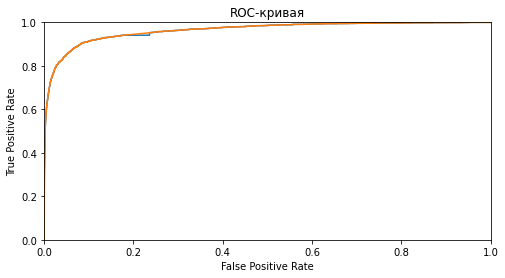

In [34]:
precision, recall, thresholds = precision_recall_curve(target_test, base_catboost_probabilities_one)
fpr, tpr, threshold = roc_curve(target_test, base_catboost_probabilities_one)
plt.figure(figsize = (8, 4))
plt.step(fpr, tpr, where = 'post')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Выводы
---
Таким образом, мы построили модель, которая показывает хороший резльтат. F1-мера составила 0.77, а, значит, цель работы выполнена. Наша модель корректно выявила 88% положительных комментариев среди всех положительных. Однако только 68% комментариев действительно оказываются положительными, если наша модель отметит их как положительный класс. Тем не менее, результаты нашей модели могут быть улучшены. Посмотрим, улучшатся ли рассмотренный выше метрики в результате `upsampling` и `downsampling`.

##### Upsample

Напишем функцию, чтобы поменять баланс классов благодаря увеличению позитивных ответов.

In [35]:
def upsample(features, target, repeat):
    
    features_zeros = features.loc[target[target["toxic"] == 0].index]
    features_ones = features.loc[target[target["toxic"] == 1].index]
    target_zeros = target[target["toxic"] == 0]
    target_ones = target[target["toxic"] == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_unsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    return shuffle(features_upsampled, target_unsampled, random_state = 12345)

In [36]:
features_upsampled, target_upsampled = upsample(base_features, base_target, 
                    ceil(base_target["toxic"].value_counts()[0] / base_target["toxic"].value_counts()[1]))

print(features_upsampled.shape)
print(target_upsampled.shape)

(288780, 1)
(288780, 1)


In [37]:
features_upsampled = count_tf_idf.fit_transform(features_upsampled["lemm_text"].values.astype('U'))
print(features_upsampled.shape)

(288780, 169757)


In [38]:
features_upsampled_train, features_upsampled_test, target_upsampled_train, target_upsampled_test = (
    train_test_split(features_upsampled, target_upsampled, test_size = 0.2, random_state = 12345)
)

print("Размерность обучающего набора признаков:", features_upsampled_train.shape)
print("Размерность тестового набора признаков:", features_upsampled_test.shape)

Размерность обучающего набора признаков: (231024, 169757)
Размерность тестового набора признаков: (57756, 169757)


In [39]:
upsampled_pool = Pool(features_upsampled_train, target_upsampled_train)

In [40]:
upsampled_catboost = CatBoostClassifier(iterations = 1000, learning_rate = 0.5, random_state = 12345)

In [41]:
upsampled_catboost.fit(upsampled_pool, early_stopping_rounds = 50, verbose = False, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [42]:
upsampled_catboost_predict = upsampled_catboost.predict(features_test)

In [43]:
confusion_matrix(target_test, upsampled_catboost_predict)

array([[27799,   830],
       [   20,  3210]])

В результате обучения модели на выборке, где доля положительных и отрицательных комментариев примерно одинаковое, наша модель корректно чуть больше 99% положительных комментариев на тестовой выборке.

In [44]:
print("Значение метрики recall:", "{:,.2%}".format(recall_score(target_test, upsampled_catboost_predict)))

Значение метрики recall: 99.38%


Среди всех предсказаний положительных комментариев нашей моделью действительно положительными оказались чуть больше 79%. 

In [45]:
print("Значение метрики precision:", "{:,.2%}".format(precision_score(target_test, upsampled_catboost_predict)))

Значение метрики precision: 79.46%


F1-мера теперь составила 0.88.

In [46]:
print("F1-метрика:", "{:,.2f}".format(f1_score(target_test, upsampled_catboost_predict)))

F1-метрика: 0.88


In [47]:
upsampled_catboost_probabilities = upsampled_catboost.predict_proba(features_test)
upsampled_catboost_probabilities_one = upsampled_catboost_probabilities[:, 1]

print("Значение метрики ROC-AUC:", 
      "{:,.2%}".format(roc_auc_score(target_test, upsampled_catboost_probabilities_one)))

Значение метрики ROC-AUC: 99.65%


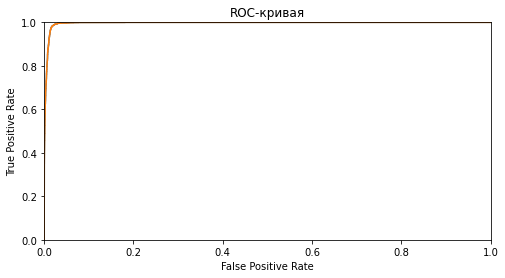

In [48]:
precision, recall, thresholds = precision_recall_curve(target_test, upsampled_catboost_probabilities_one)
fpr, tpr, threshold = roc_curve(target_test, upsampled_catboost_probabilities_one)
plt.figure(figsize = (8, 4))
plt.step(fpr, tpr, where = 'post')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Выводы
---
Таким образом, методика `upsampling` привела к улучшению модели. Обучившись на наборе данных с примерно одинаковыми классами, наша модель начала еще лучше предсказывать положительные комментарии. Это выражается в улучшении всех рассматриваемых нами метрик (`recall`, `precision`, `F1`, `AUC-ROC`).

##### Downsample

In [49]:
def downsample(features, target, fraction):
    
    features_zeros = features.loc[target[target["toxic"] == 0].index]
    features_ones = features.loc[target[target["toxic"] == 1].index]
    target_zeros = target[target["toxic"] == 0]
    target_ones = target[target["toxic"] == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac = fraction, random_state = 12345)] + [features_ones]
    )
    
    target_downsampled = pd.concat(
        [target_zeros.sample(frac = fraction, random_state = 12345)] + [target_ones]
    )

    features_downsampled, target_downsampled = (
        shuffle(features_downsampled, target_downsampled, random_state = 12345)
    )

    return features_downsampled, target_downsampled

In [50]:
features_downsampled, target_downsampled = downsample(base_features, base_target, 
                    base_target["toxic"].value_counts()[1] / base_target["toxic"].value_counts()[0])

print(features_downsampled.shape)
print(target_downsampled.shape)

(32372, 1)
(32372, 1)


In [51]:
features_downsampled = count_tf_idf.fit_transform(features_downsampled["lemm_text"].values.astype('U'))
print(features_downsampled.shape)

(32372, 62474)


In [52]:
features_downsampled_train, features_downsampled_test, target_downsampled_train, target_downsampled_test = (
    train_test_split(features_downsampled, target_downsampled, test_size = 0.2, random_state = 12345)
)

print("Размерность обучающего набора признаков:", features_downsampled_train.shape)
print("Размерность тестового набора признаков:", features_downsampled_test.shape)

Размерность обучающего набора признаков: (25897, 62474)
Размерность тестового набора признаков: (6475, 62474)


In [53]:
downsampled_pool = Pool(features_downsampled_train, target_downsampled_train)

In [54]:
downsampled_catboost = CatBoostClassifier(iterations = 1000, learning_rate = 0.5, random_state = 12345)

In [55]:
downsampled_catboost.fit(downsampled_pool, early_stopping_rounds = 50, verbose = False, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [56]:
downsampled_catboost_predict = downsampled_catboost.predict(features_test)

In [57]:
confusion_matrix(target_test, downsampled_catboost_predict)

array([[27620,  1009],
       [ 3142,    88]])

In [58]:
print("Значение метрики recall:", "{:,.2%}".format(recall_score(target_test, downsampled_catboost_predict)))

Значение метрики recall: 2.72%


In [59]:
print("Значение метрики precision:", "{:,.2%}".format(precision_score(target_test, downsampled_catboost_predict)))

Значение метрики precision: 8.02%


Несмотря на то, что уменьшили количество негативных комментариев, сбалансировав их с положительными комментариями, общая обучающая выборка стала маленькой, в результате чего метрики существенно ухудшились.

In [60]:
print("F1-метрика:", "{:,.2f}".format(f1_score(target_test, downsampled_catboost_predict)))

F1-метрика: 0.04


In [61]:
downsampled_catboost_probabilities = downsampled_catboost.predict_proba(features_test)
downsampled_catboost_probabilities_one = downsampled_catboost_probabilities[:, 1]

print("Значение метрики ROC-AUC:", 
      "{:,.2%}".format(roc_auc_score(target_test, downsampled_catboost_probabilities_one)))

Значение метрики ROC-AUC: 47.98%


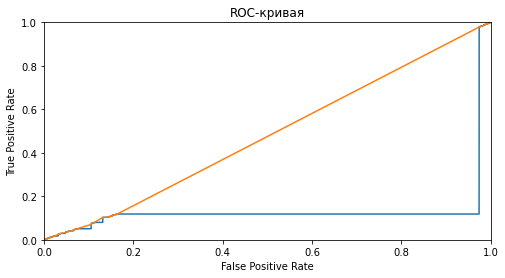

In [62]:
precision, recall, thresholds = precision_recall_curve(target_test, downsampled_catboost_probabilities_one)
fpr, tpr, threshold = roc_curve(target_test, downsampled_catboost_probabilities_one)
plt.figure(figsize = (8, 4))
plt.step(fpr, tpr, where = 'post')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Выводы
---
Таким образом, техника `downsampling` привела к существенному ухудшению метрик. Наша модель стала даже хуже, чем базовая, которую мы обучали без корректировки дисбаланса классов.

### Шаг 3. Общие выводы
---
В данной работе:
1. мы провели подготовку датасета с комментариями пользователей; 
2. мы перевели их в векторный вид, понятный для компьютера; 
3. мы проделали необходимые шаги, чтобы алгоритмы понимали тональность комментариев;
4. мы оцениили модель до исправления дисбаланса классов и выбрали лучшую среди них;
5. мы применили две техники для исправления дисбаланса классов и посмотрили, как они влияют на метрики.

Таким образом, лучшей моделью стала `CatBoostClassifier` с 1 тыс. деревьев и коэффициентом обучения 0.5. До исправления баланса классов F1-мера составила 0.77, `recall` - 68.02%, `precision` - 88.30%, `ROC-AUC` - 96.34%.

В результате применения `upsampling` модель улучшилась: F1-мера составила 0.88, `recall` - 99.38%, `precision` - 79.46%, `ROC-AUC` - 99.65%.

Обратный эффект мы получили в результате применения `downsampling`. Все метрики существенно ухудшились.